## Import

In [2]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [4]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':50,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [6]:
all_img_list = glob.glob('train/*/*')
# all_img_list = [f.replace(os.sep, '/') for f in all_img_list]

In [7]:
all_img_list

['train\\가구수정\\0.png',
 'train\\가구수정\\1.png',
 'train\\가구수정\\10.png',
 'train\\가구수정\\11.png',
 'train\\가구수정\\2.png',
 'train\\가구수정\\3.png',
 'train\\가구수정\\4.png',
 'train\\가구수정\\5.png',
 'train\\가구수정\\6.png',
 'train\\가구수정\\7.png',
 'train\\가구수정\\8.png',
 'train\\가구수정\\9.png',
 'train\\걸레받이수정\\0.png',
 'train\\걸레받이수정\\1.png',
 'train\\걸레받이수정\\10.png',
 'train\\걸레받이수정\\100.png',
 'train\\걸레받이수정\\101.png',
 'train\\걸레받이수정\\102.png',
 'train\\걸레받이수정\\103.png',
 'train\\걸레받이수정\\104.png',
 'train\\걸레받이수정\\105.png',
 'train\\걸레받이수정\\106.png',
 'train\\걸레받이수정\\107.png',
 'train\\걸레받이수정\\108.png',
 'train\\걸레받이수정\\109.png',
 'train\\걸레받이수정\\11.png',
 'train\\걸레받이수정\\110.png',
 'train\\걸레받이수정\\111.png',
 'train\\걸레받이수정\\112.png',
 'train\\걸레받이수정\\113.png',
 'train\\걸레받이수정\\114.png',
 'train\\걸레받이수정\\115.png',
 'train\\걸레받이수정\\116.png',
 'train\\걸레받이수정\\117.png',
 'train\\걸레받이수정\\118.png',
 'train\\걸레받이수정\\119.png',
 'train\\걸레받이수정\\12.png',
 'train\\걸레받이수정\\120.png',
 'train\\걸레받이수정\\121.png',


In [8]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split(os.sep)[-2])

In [9]:
df

,img_path,label
0,train\가구수정\0.png,가구수정
1,train\가구수정\1.png,가구수정
2,train\가구수정\10.png,가구수정
3,train\가구수정\11.png,가구수정
4,train\가구수정\2.png,가구수정
...,...,...
3452,train\훼손\995.png,훼손
3453,train\훼손\996.png,훼손
3454,train\훼손\997.png,훼손
3455,train\훼손\998.png,훼손


In [17]:
train_data, val_data, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

## Label-Encoding

In [43]:
le = preprocessing.LabelEncoder()

train_data['label'] = le.fit_transform(train['label'])

train_data['label_multi_hot'] = np.eye(len(le.classes_), dtype = np.int32)[train_data['label'].tolist()].tolist()

val_data['label'] = le.transform(val['label'])
val_data['label_multi_hot'] = np.eye(len(le.classes_), dtype = np.int32)[val_data['label'].tolist()].tolist()

## weighted random sampler

In [ ]:
WeightedRandomSampler()

## CustomDataset

In [44]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        try :
            image = np.array(Image.open(img_path))
        except :
            print(img_path)
            raise
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [45]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [47]:
# train_multi_hot_for_sampler = 

# train_sampler = MultilabelBalancedRandomSampler()

train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [48]:
next(iter(train_loader))

[tensor([[[[-0.5938, -0.4568, -0.2342,  ..., -0.8849, -0.9192, -0.2513],
           [-0.5767, -0.3712, -0.2856,  ..., -0.9534, -0.6452, -0.4226],
           [-0.5767, -0.6281, -0.3883,  ..., -0.9020, -0.7993, -0.3541],
           ...,
           [-0.6452, -0.5253, -0.4226,  ..., -0.9877, -0.5767, -0.9020],
           [-0.3883, -0.3198, -0.4054,  ..., -0.8849, -0.7822, -0.8164],
           [-0.4226, -0.5253, -0.4911,  ..., -0.7993, -0.8678, -0.6109]],
 
          [[-0.4776, -0.3375, -0.0924,  ..., -0.7752, -0.8102, -0.1275],
           [-0.4426, -0.2325, -0.1450,  ..., -0.8452, -0.5301, -0.3025],
           [-0.4426, -0.5126, -0.2675,  ..., -0.7927, -0.6877, -0.2325],
           ...,
           [-0.5301, -0.4076, -0.3025,  ..., -0.8627, -0.4426, -0.7752],
           [-0.2675, -0.1975, -0.2850,  ..., -0.7752, -0.6702, -0.7052],
           [-0.3025, -0.4076, -0.3725,  ..., -0.6877, -0.7577, -0.5126]],
 
          [[-0.2881, -0.1487,  0.0779,  ..., -0.5844, -0.6367,  0.0605],
           [-

## Model Define

In [49]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

## Train

In [69]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [70]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

## Run!!

In [71]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.49350] Val Loss : [2.52430] Val Weighted F1 Score : [0.24344]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.65668] Val Loss : [2.58646] Val Weighted F1 Score : [0.30734]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.30694] Val Loss : [2.44178] Val Weighted F1 Score : [0.35516]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.15397] Val Loss : [1.66127] Val Weighted F1 Score : [0.54906]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.10006] Val Loss : [1.90682] Val Weighted F1 Score : [0.52279]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.08348] Val Loss : [2.51779] Val Weighted F1 Score : [0.40472]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10002] Val Loss : [2.27213] Val Weighted F1 Score : [0.43126]
Epoch 00007: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.05938] Val Loss : [1.55155] Val Weighted F1 Score : [0.63154]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.02545] Val Loss : [1.62742] Val Weighted F1 Score : [0.65921]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.01633] Val Loss : [1.22698] Val Weighted F1 Score : [0.74052]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.02117] Val Loss : [2.15870] Val Weighted F1 Score : [0.58615]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.00758] Val Loss : [1.32112] Val Weighted F1 Score : [0.73039]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.01217] Val Loss : [2.27234] Val Weighted F1 Score : [0.51867]
Epoch 00013: reducing learning rate of group 0 to 7.5000e-05.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.00715] Val Loss : [1.31333] Val Weighted F1 Score : [0.74545]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.01030] Val Loss : [1.46671] Val Weighted F1 Score : [0.70064]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.00586] Val Loss : [1.39972] Val Weighted F1 Score : [0.71530]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.00664] Val Loss : [1.53015] Val Weighted F1 Score : [0.69818]
Epoch 00017: reducing learning rate of group 0 to 3.7500e-05.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.00578] Val Loss : [1.37561] Val Weighted F1 Score : [0.73926]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.00294] Val Loss : [1.31425] Val Weighted F1 Score : [0.74102]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.00788] Val Loss : [1.30069] Val Weighted F1 Score : [0.75190]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.00542] Val Loss : [1.29755] Val Weighted F1 Score : [0.75673]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.01108] Val Loss : [1.34035] Val Weighted F1 Score : [0.72773]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.00326] Val Loss : [1.29626] Val Weighted F1 Score : [0.73409]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.00544] Val Loss : [1.30986] Val Weighted F1 Score : [0.74849]
Epoch 00024: reducing learning rate of group 0 to 1.8750e-05.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.00473] Val Loss : [1.33722] Val Weighted F1 Score : [0.74376]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.00220] Val Loss : [1.33061] Val Weighted F1 Score : [0.74045]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.00283] Val Loss : [1.32938] Val Weighted F1 Score : [0.74592]
Epoch 00027: reducing learning rate of group 0 to 9.3750e-06.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.00394] Val Loss : [1.34059] Val Weighted F1 Score : [0.74446]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.00376] Val Loss : [1.33663] Val Weighted F1 Score : [0.74581]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.00397] Val Loss : [1.33579] Val Weighted F1 Score : [0.74471]
Epoch 00030: reducing learning rate of group 0 to 4.6875e-06.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.00238] Val Loss : [1.33359] Val Weighted F1 Score : [0.74386]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.00331] Val Loss : [1.34937] Val Weighted F1 Score : [0.74231]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.00455] Val Loss : [1.33370] Val Weighted F1 Score : [0.74621]
Epoch 00033: reducing learning rate of group 0 to 2.3437e-06.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.00627] Val Loss : [1.32814] Val Weighted F1 Score : [0.75075]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.00376] Val Loss : [1.33379] Val Weighted F1 Score : [0.74279]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.00189] Val Loss : [1.33660] Val Weighted F1 Score : [0.74220]
Epoch 00036: reducing learning rate of group 0 to 1.1719e-06.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.00342] Val Loss : [1.33500] Val Weighted F1 Score : [0.74449]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.00382] Val Loss : [1.33473] Val Weighted F1 Score : [0.74363]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.00489] Val Loss : [1.34315] Val Weighted F1 Score : [0.74407]
Epoch 00039: reducing learning rate of group 0 to 5.8594e-07.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.00532] Val Loss : [1.33163] Val Weighted F1 Score : [0.74490]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.00456] Val Loss : [1.33597] Val Weighted F1 Score : [0.74593]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.00403] Val Loss : [1.33873] Val Weighted F1 Score : [0.74334]
Epoch 00042: reducing learning rate of group 0 to 2.9297e-07.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.00330] Val Loss : [1.34607] Val Weighted F1 Score : [0.74355]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.00499] Val Loss : [1.34256] Val Weighted F1 Score : [0.74297]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.00727] Val Loss : [1.33107] Val Weighted F1 Score : [0.74414]
Epoch 00045: reducing learning rate of group 0 to 1.4648e-07.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.00194] Val Loss : [1.33830] Val Weighted F1 Score : [0.74481]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.00284] Val Loss : [1.33584] Val Weighted F1 Score : [0.74909]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.00193] Val Loss : [1.33887] Val Weighted F1 Score : [0.74352]
Epoch 00048: reducing learning rate of group 0 to 7.3242e-08.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.00382] Val Loss : [1.34058] Val Weighted F1 Score : [0.74106]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [50], Train Loss : [0.00259] Val Loss : [1.34149] Val Weighted F1 Score : [0.74261]


## Inference

In [73]:
test = pd.read_csv('./test.csv')

,id,img_path
0,TEST_000,./test/000.png
1,TEST_001,./test/001.png
2,TEST_002,./test/002.png
3,TEST_003,./test/003.png
4,TEST_004,./test/004.png
...,...,...
787,TEST_787,./test/787.png
788,TEST_788,./test/788.png
789,TEST_789,./test/789.png
790,TEST_790,./test/790.png


In [135]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [136]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [137]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

## Submission

In [138]:
submit = pd.read_csv('./sample_submission.csv')

In [139]:
submit

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손
...,...,...
787,TEST_787,훼손
788,TEST_788,훼손
789,TEST_789,훼손
790,TEST_790,훼손


In [140]:
submit['label'] = preds

In [141]:
le.encoder

AttributeError: 'LabelEncoder' object has no attribute 'encoder'

In [143]:
submit.to_csv('./baseline_submit.csv', index=False)

(array([753.,   0.,  33.,   0.,   0.,   4.,   0.,   1.,   0.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

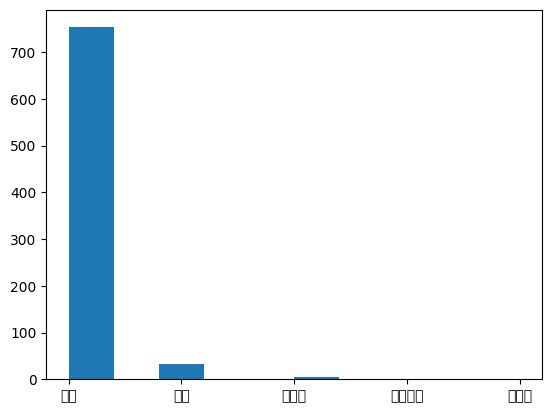

In [144]:

plt.hist(submit['label'])